# xG Modelling

xG : Expected Goals

## Setup

In [16]:
%matplotlib inline

import pandas as pd
import numpy as np
import json
import os
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from mplsoccer import VerticalPitch
import seaborn as sns

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [17]:
notebook_directory = os.getcwd()
course_directory = notebook_directory.rsplit("\\Notebooks")[0]
os.chdir(course_directory)

## Data

In [18]:
train_df = pd.DataFrame()

for i in range(13):
    with open(f"data\wyscout\events_England_{i+1}.json") as file:
        data = json.load(file)    
    train_df = pd.concat([train_df, pd.DataFrame(data)])

train_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
43145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
43147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


### Shot Positions
- Need to scale the position of the shots to taking place on a `105*68` pitch, with `x=0` being the goal.
- C is an auxillary variable which will be used to calculate the distance and angle of a shot = distance from a point to the horizontal line through the middle of the pitch.
- Angle Formula [(Sumpter, 2017)](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760):

$$
tan \theta = \frac{7.32x}{x^2 + y^2 - (\frac{7.32}{2})^2}
$$

- Distance = distance on Euclidean plane.

In [42]:
shots_df = train_df[train_df['subEventName'] == "Shot"].copy()
shots_df["X"] = shots_df["positions"].apply(lambda cell: (100-cell[0]["x"]) * 105/100)
shots_df["Y"] = shots_df["positions"].apply(lambda cell: cell[0]["y"] * 68/100)
shots_df["C"] = shots_df["positions"].apply(lambda cell: abs(100-cell[0]["y"] - 50) * 68/100)

shots_df["Distance"] = np.sqrt(shots_df["X"] ** 2 + shots_df["C"] ** 2)
shots_df["Angle"] = np.where(np.arctan(7.32 * shots_df["X"] / (shots_df["X"] ** 2 + shots_df["C"] ** 2 - (7.32/2)**2)) > 0,  np.arctan(7.32 * shots_df["X"] /(shots_df["X"]**2 + shots_df["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots_df["X"] /(shots_df["X"]**2 + shots_df["C"]**2 - (7.32/2)**2)) + np.pi)
shots_df["Goal"] = shots_df["tags"].apply(lambda x: 1 if {"id":101} in x else 0).astype(object)
shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,35.36,1.36,4.414703,1.375115,1
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,22.44,11.56,23.057235,0.274666,0
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,20.40,13.60,29.563872,0.219665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42945,10,Shot,"[{'id': 401}, {'id': 1212}, {'id': 1802}]",8561,"[{'y': 45, 'x': 72}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,1972.969422,100,251596053,29.40,30.60,3.40,29.595946,0.244517,0
43023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,100,251596096,14.70,22.44,11.56,18.700898,0.309646,1
43051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,100,251596357,12.60,42.16,8.16,15.011516,0.410444,0
43055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,100,251596359,8.40,25.84,8.16,11.710918,0.461143,0


#### Plot Shot Location

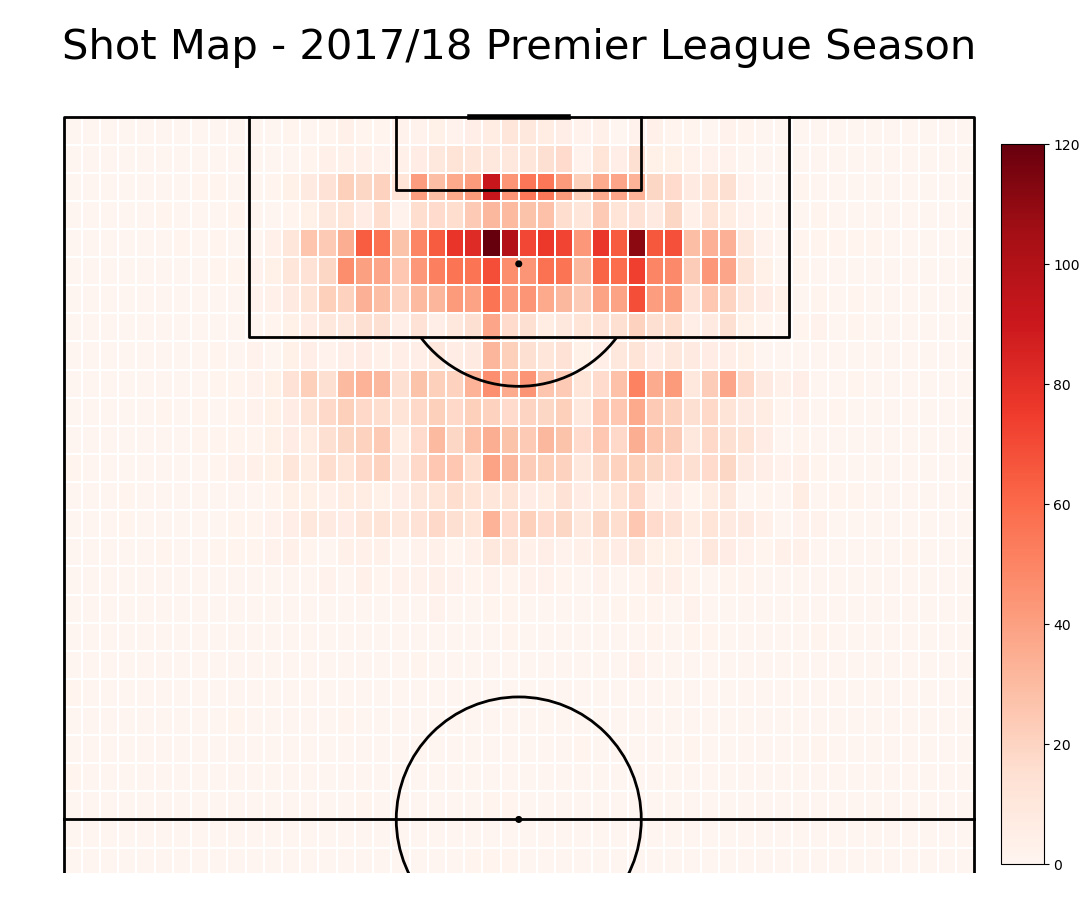

In [21]:
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic_shots = pitch.bin_statistic(105 - shots_df["X"], shots_df["Y"], bins=50)

pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap="Reds", edgecolor="white", linewidth=0.01, vmax=120)

ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Shot Map - 2017/18 Premier League Season", fontsize=30)

plt.show();

#### Plot Goal Location

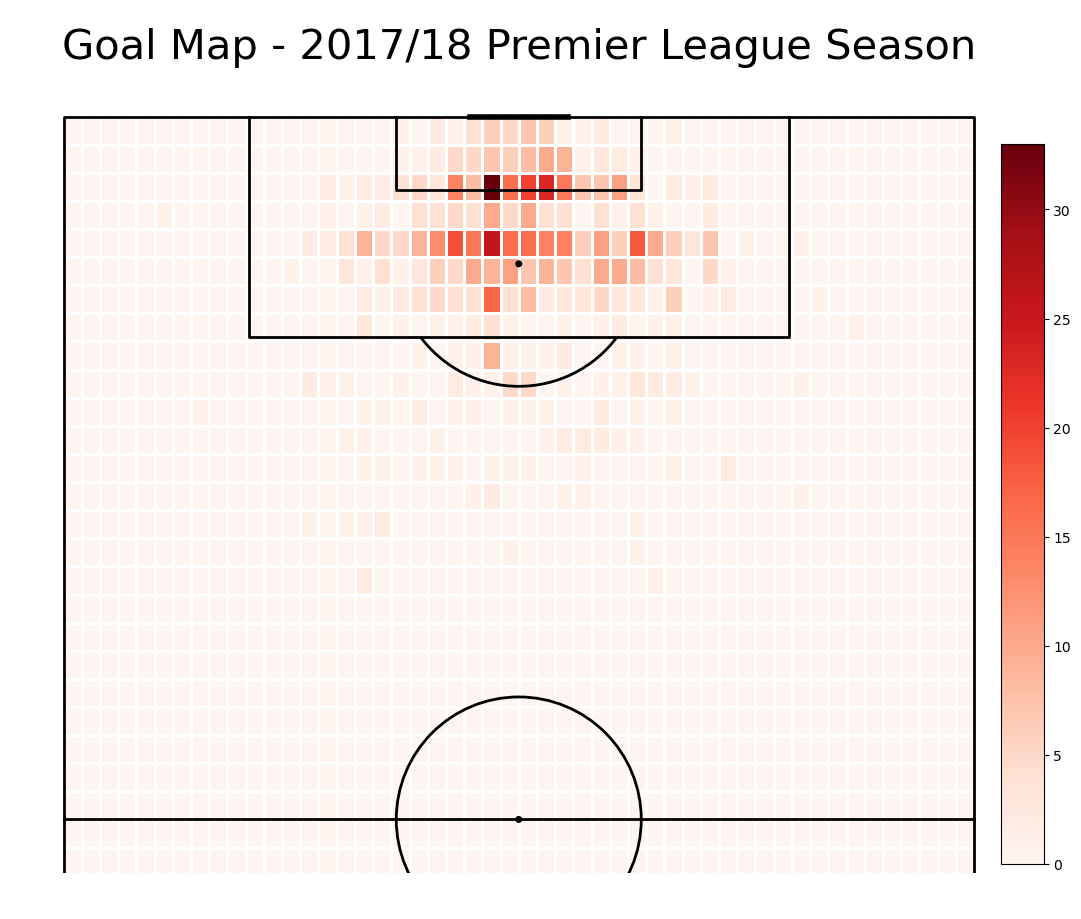

In [22]:
goals = shots_df.loc[shots_df["Goal"] == 1].copy()
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic_goals = pitch.bin_statistic(105 - goals["X"], goals["Y"], bins=50)

pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap="Reds", edgecolor="white")

ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Goal Map - 2017/18 Premier League Season", fontsize=30)

plt.show();

#### Probability of Scoring based on location

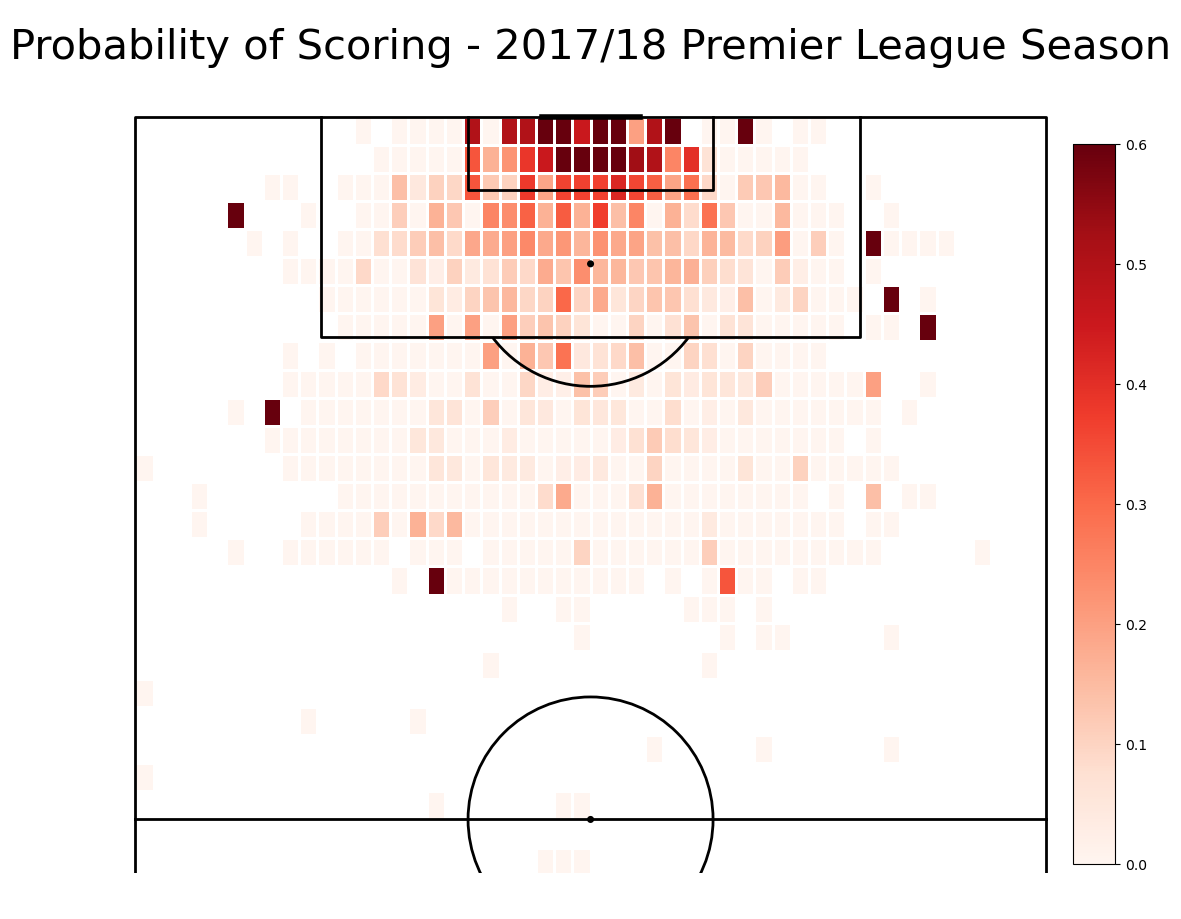

In [23]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(105 - shots_df.X, shots_df.Y, bins = 50)

#normalize number of goals by number of shots 
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]

#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of Scoring - 2017/18 Premier League Season' , fontsize = 30)
plt.show()

### xG Model

- Using logistic regression.
- Logistic Formula is:

$$
p(x) = \frac{1}{1+e^{-(x-\mu)/s}}
$$

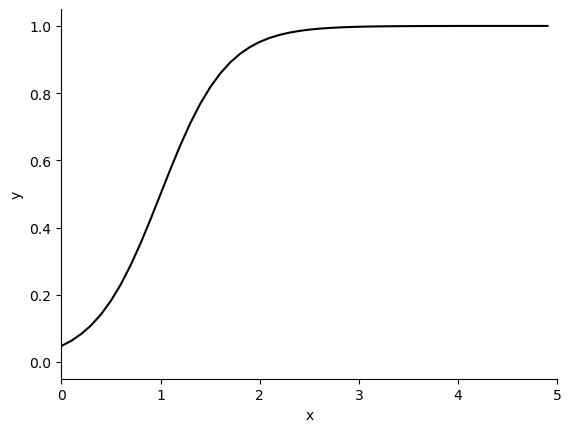

In [24]:
b = [3,-3]
x = np.arange(5, step=0.1)
y = 1/(1 + np.exp(b[0]+b[1]*x))

fig, ax = plt.subplots()
plt.ylim((-0.05, 1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.plot(x,y, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show();

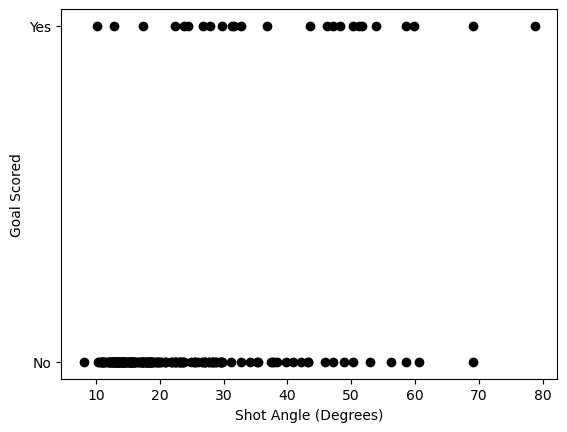

In [25]:
first_200_shots = shots_df.iloc[:200]
fig, ax = plt.subplots()
ax.plot(first_200_shots["Angle"]*180/np.pi, first_200_shots["Goal"], linestyle='none', marker='.', markersize=12, color="black")
ax.set_ylabel("Goal Scored")
ax.set_xlabel("Shot Angle (Degrees)")
plt.ylim((-0.05, 1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(["No", "Yes"])
plt.show();

In [26]:
# shots_df["Angle_Degrees"] = shots_df["Angle"]*180/np.pi
# goals["Angle_Degrees"] = goals["Angle"]*180/np.pi

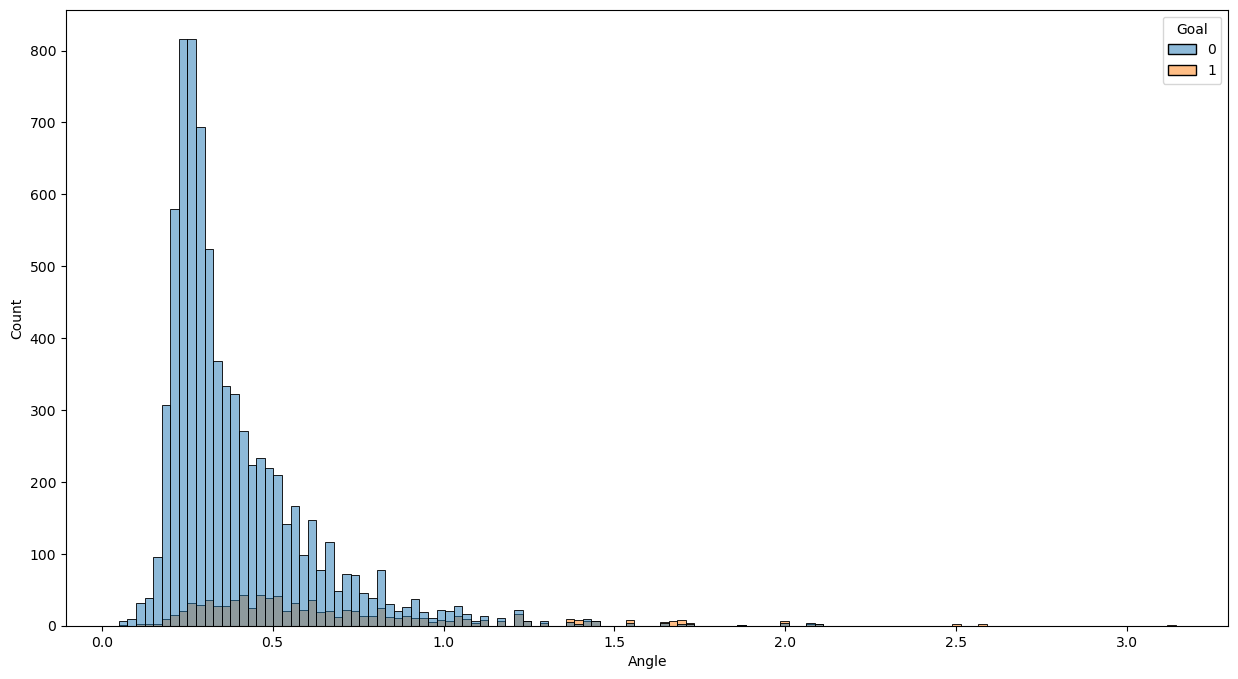

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(shots_df, x="Angle", hue="Goal");

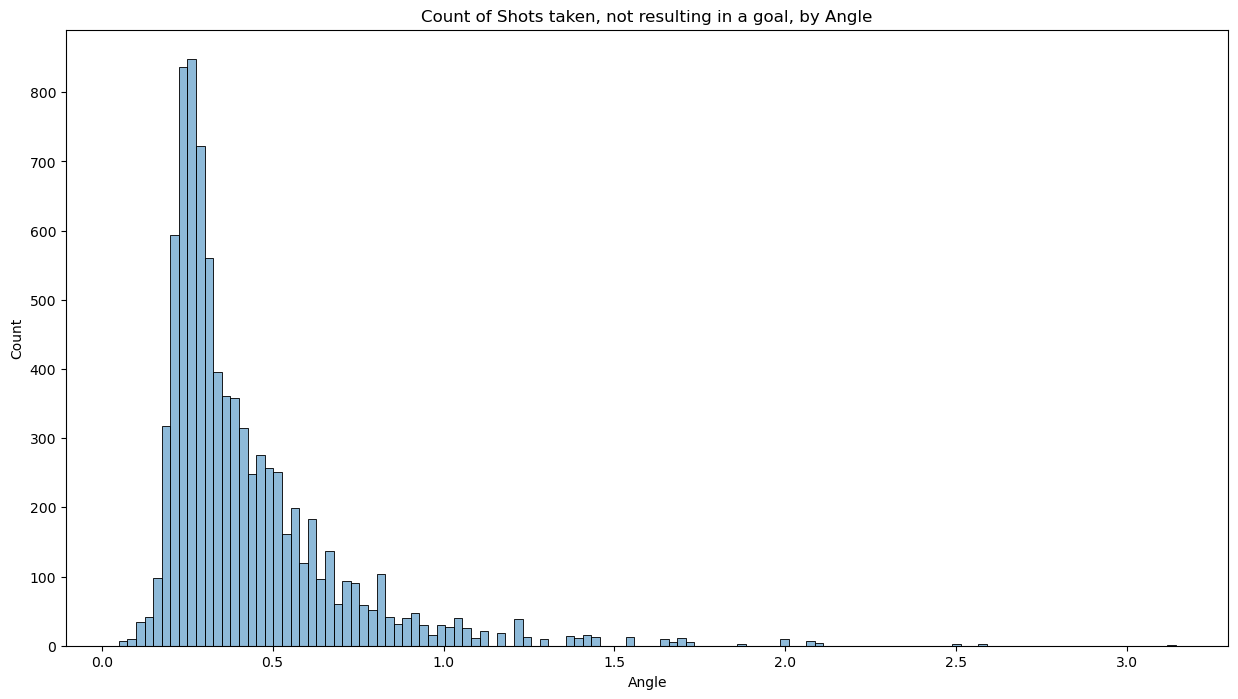

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(shots_df, x="Angle", alpha=0.5);
ax.set_title("Count of Shots taken, not resulting in a goal, by Angle");

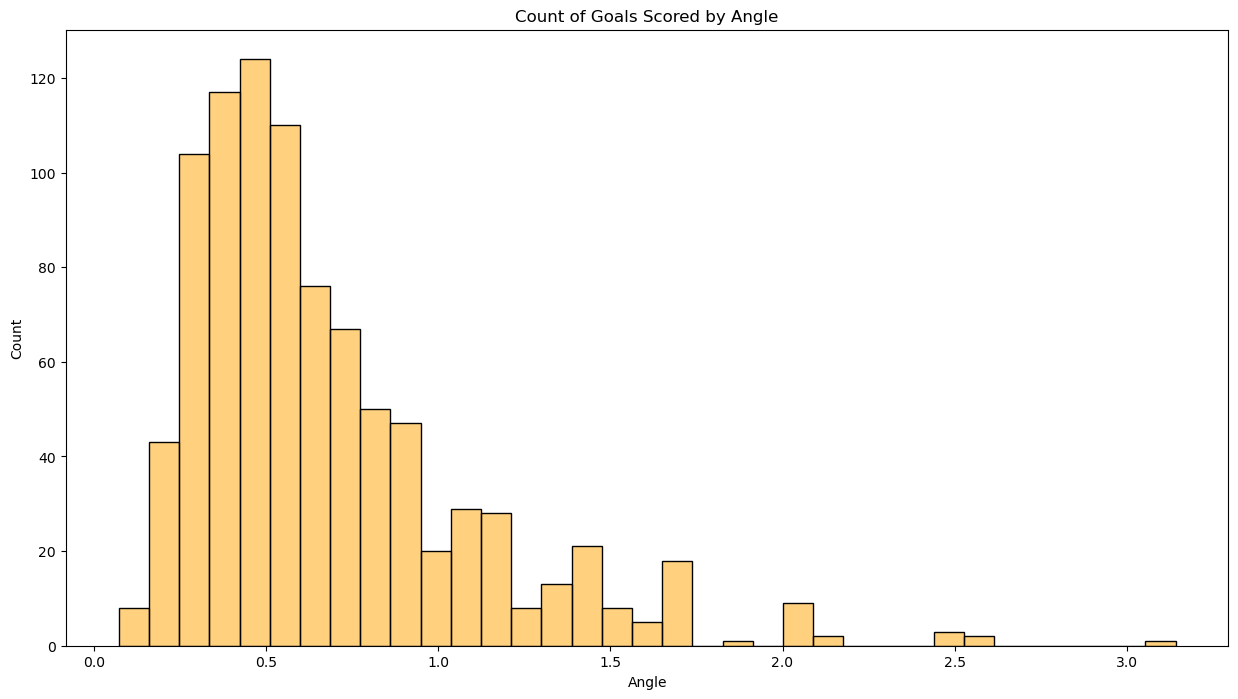

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(goals, x="Angle", color="orange", alpha=0.5)
ax.set_title("Count of Goals Scored by Angle");

#### Relationship betweeen angle and probability of scoring a goal
- First we'll plot a simple dot plot showing the relationship between the angle of a shot and the probability that it results in a goal.
- Then we can try fitting the logistic regression model for xG.

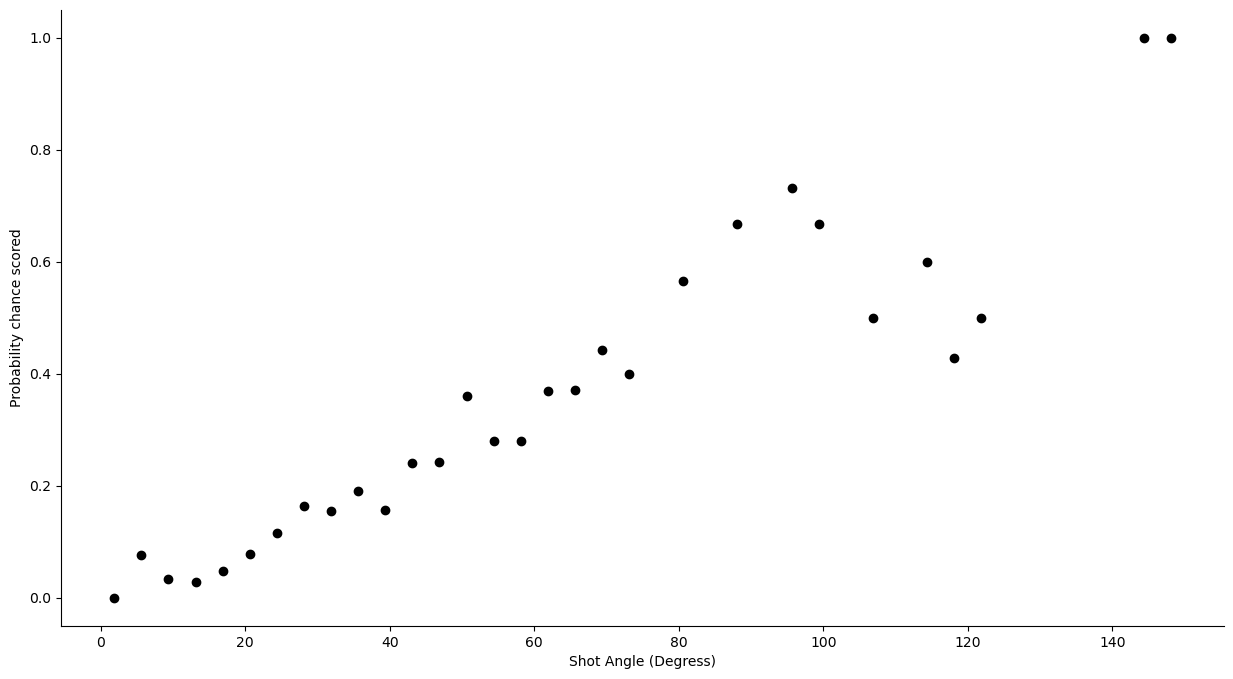

In [31]:
shotcount_dist = np.histogram(shots_df["Angle"]*180/np.pi, bins=40, range=[0,150])
goalcount_dist = np.histogram(goals["Angle"]*180/np.pi, bins=40, range=[0,150])
np.seterr(divide="ignore", invalid="ignore")

prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])

angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:]) / 2

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(midangle, prob_goal, linestyle="None", marker=".", markersize=12, color="black")
ax.set_ylabel("Probability chance scored")
ax.set_xlabel("Shot Angle (Degress)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show();

##### Fitting the Logistic Regression Model

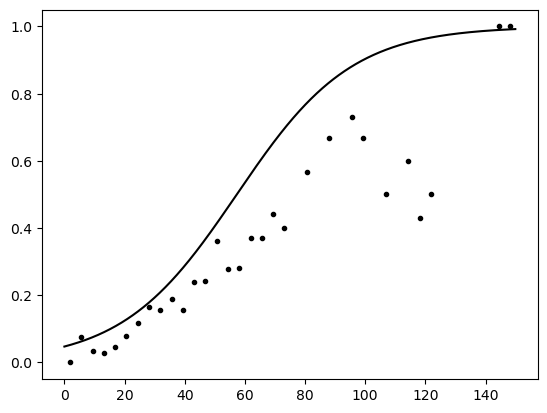

In [32]:
fig, ax = plt.subplots()
b = [3, -3]
x = np.arange(150, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))
ax.plot(midangle, prob_goal, linestyle="none", marker='.', color="black")
ax.plot(x, y, color="black")
plt.show();

##### Calculating the log-likelihood.

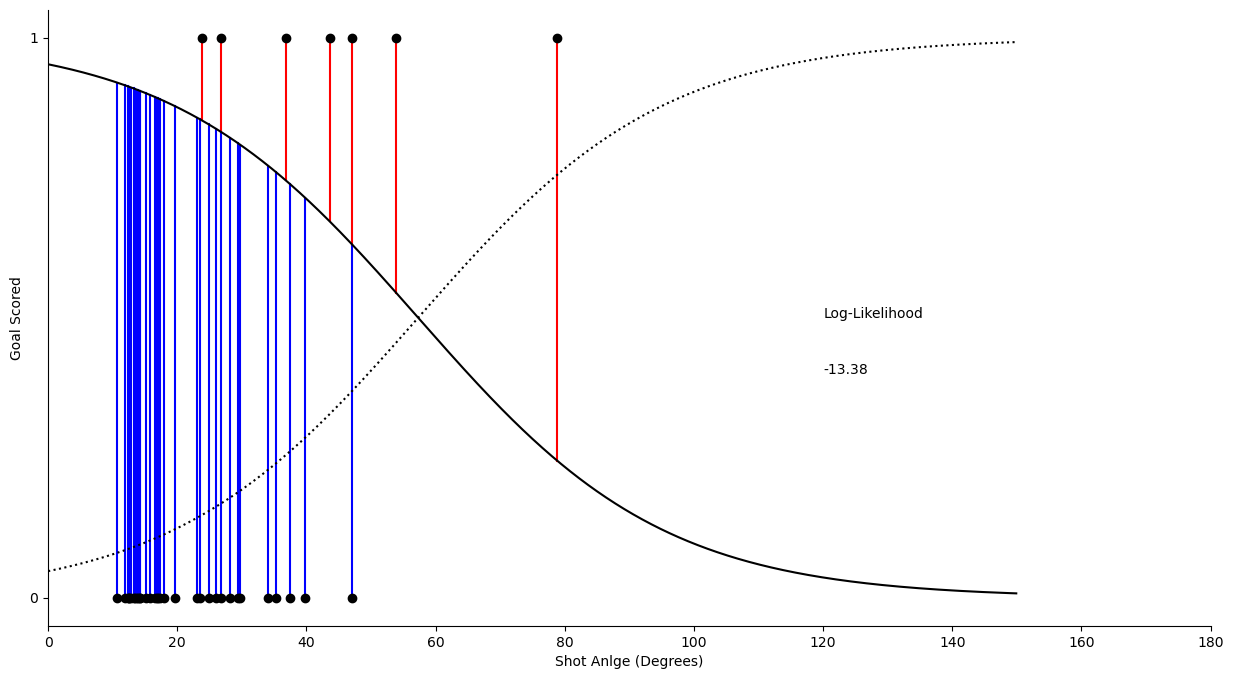

In [34]:
xG = 1 / (1 + np.exp(b[0] + b[1] * shots_df["Angle"]))
shots_df["xG"] = xG
shots_40 = shots_df.iloc[:40]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(shots_40["Angle"]*180/np.pi, shots_40["Goal"], linestyle="none", marker=".", markersize=12, color="black", zorder=3)
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)

loglikelihood = 0
for item, shot in shots_40.iterrows():
    angle = shot["Angle"] * 180/np.pi
    if shot["Goal"] == 1:
        loglikelihood = loglikelihood + np.log(shot["xG"])
        ax.plot([angle, angle], [shot["Goal"], 1-shot["xG"]], color="red", zorder=1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot["xG"])
        ax.plot([angle, angle], [shot["Goal"], 1-shot["xG"]], color="blue", zorder=1)

ax.set_ylabel("Goal Scored")
ax.set_xlabel("Shot Anlge (Degrees)")
ax.set_yticks([0,1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.ylim((-0.05, 1.05))
plt.xlim((0,180))
plt.text(120, 0.5, "Log-Likelihood")
plt.text(120, 0.4, str(loglikelihood)[:6])
plt.show();

#### Improving the model
- Best parameteres are those which maximise the log-likelihood.

In [43]:
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Tue, 09 Jan 2024   Deviance:                       5122.5
Time:                            21:27:20   Pearson chi2:                 7.96e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [45]:
b = test_model.params
xG_prob = 1 / (1 + np.exp(b[0] + b[1] * midangle*np.pi/180))
xG_prob

array([0.03131903, 0.03748555, 0.04481005, 0.0534862 , 0.06373015,
       0.07577899, 0.08988709, 0.10631961, 0.12534248, 0.14720831,
       0.17213788, 0.20029767, 0.23177438, 0.2665489 , 0.30447302,
       0.34525299, 0.38844446, 0.43346207, 0.47960536, 0.52609926,
       0.57214495, 0.61697394, 0.65989798, 0.70034799, 0.7378979 ,
       0.77227241, 0.80334022, 0.83109658, 0.85563942, 0.87714319,
       0.89583374, 0.91196623, 0.92580716, 0.93762083, 0.94765976,
       0.95615863, 0.96333087, 0.96936736, 0.97443649, 0.97868522])

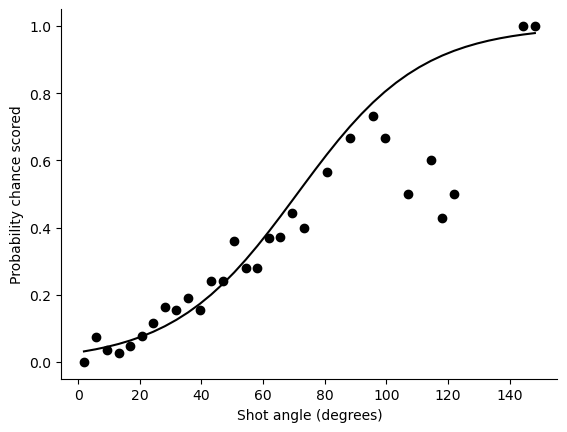

In [47]:
fig, ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle="None", marker=".", markersize=12, color="black")
ax.plot(midangle, xG_prob, linestyle="solid", color="black")
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show();